# ML in Action - Decision  Training for Water Body Mapping

This is an introductory notebook to familiarize  with training and evaluation techniques for Machine Learning (ML). For this work, we will use data from the LISS-III instrument from ResourceSat satellite  and a Decision Tree algorithm to perform water classification.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from osgeo import gdal
from pathlib import Path
import os
from sklearn import tree
from matplotlib import pyplot as plt
import os
import time
from random import randint
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [ ]:
os.chdir('/content/drive/MyDrive/DLP_Data/ML')

In [ ]:
df = pd.read_csv(r'water_train.csv', index_col=0)

In [ ]:
df.head()

,Band2,Band3,Band4,Band5,Water
0,90,59,58,12,1
1,94,57,62,14,1
2,88,55,56,15,1
3,87,54,58,12,1
4,94,59,61,16,1


In [ ]:
y = df.pop('Water')
X = df

In [ ]:
RANDOM_STATE = 42

After we read our dataset, we proceed to split it into training and test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=RANDOM_STATE,train_size=0.80)

In [ ]:
y_train.value_counts(), y_test.value_counts()

(Water
 1    404
 0    396
 Name: count, dtype: int64,
 Water
 0    104
 1     96
 Name: count, dtype: int64)

In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Band2,800.0,90.60875,14.598444,55.0,86.0,90.0,95.00,303.0
Band3,800.0,64.92500,16.198066,37.0,57.0,60.0,69.25,266.0
Band4,800.0,112.25750,55.919495,51.0,60.0,94.5,165.00,365.0
Band5,800.0,62.81250,56.775714,9.0,13.0,39.5,109.25,305.0


In [ ]:
y_train.describe().T

,Water
count,800.000000
mean,0.505000
std,0.500288
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


## 2. Model definition and training

In this section we will define our model and train it using our dataset. The hyperparameters listed below are the default from the scikit-learn library, but these are usually very similar across other programming languages. Some of the most useful parameters to know about from the Random Forest are:
- n_estimators: number of trees in the forest
- max_features: max number of features considered for splitting a node
- max_depth: max number of levels in each decision tree
- min_samples_split: min number of data points placed in a node before the node is split
- min_samples_leaf: min number of data points allowed in a leaf node
- bootstrap: method for sampling data points (with or without replacement)

In [ ]:
hyperparameters = {
                   'criterion':'gini',
                   'max_depth':None,
                   'min_samples_split':2,
                   'min_samples_leaf':1,
                   'min_weight_fraction_leaf':0.0,
                   'max_features':'sqrt',
                   'max_leaf_nodes':None,
                   'min_impurity_decrease':0.0,
                   'random_state':42,
                   'class_weight':None,
                   'ccp_alpha':0.0,
                   }

In [ ]:
classifier = DT(**hyperparameters)

In [ ]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_features='sqrt', random_state=42)

In [ ]:
score = classifier.score(X_test, y_test)
print('Average accuracy score: {}'.format(score))

Average accuracy score: 1.0


It is to perform predictions once we have datasets in dataframe format.

In [ ]:
#train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)


In [ ]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
#cm = confusion_matrix(y_test, test_predictions, labels)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        96

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
cm = confusion_matrix(y_test, test_predictions, labels=[0, 1])

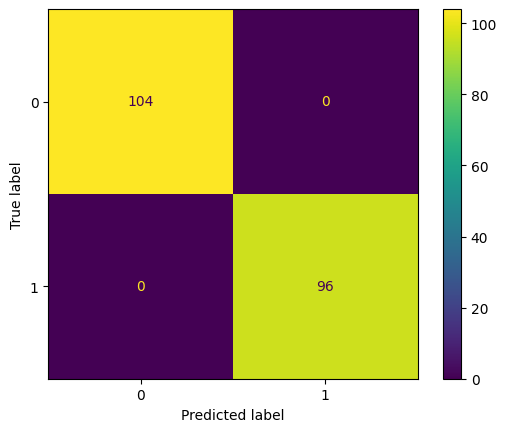

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_)
disp.plot()

## Understanding the decision tree structure

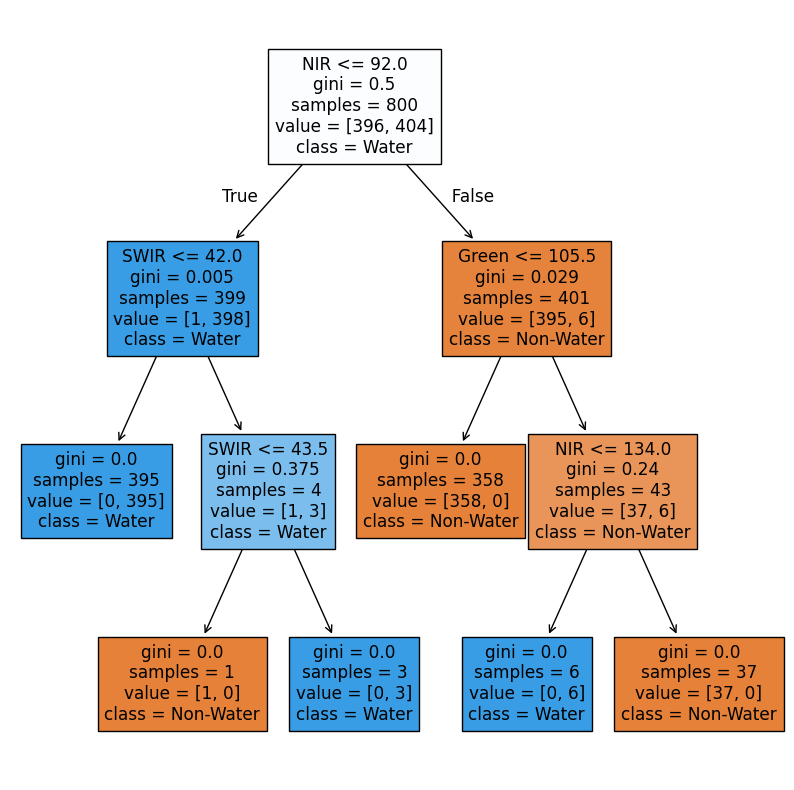

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
tree.plot_tree(classifier, feature_names=['Green', 'Red', 'NIR', 'SWIR'],
               class_names=['Non-Water', 'Water'], ax=ax,filled=True)
plt.show()

3. Raster Inference

Here we can proceed to perform inference using raster objects.

We can select all individual band TIF images and stack them to form the raster needed as input to the model.

In [ ]:
input_files = ['Tehri/L3-NH44G07-096-049-05Apr19-BAND2.tif',
               'Tehri/L3-NH44G07-096-049-05Apr19-BAND3.tif',
               'Tehri/L3-NH44G07-096-049-05Apr19-BAND4.tif',
               'Tehri/L3-NH44G07-096-049-05Apr19-BAND5.tif']

In [ ]:
data = []
for file in input_files:
    ds = gdal.Open(file)
    data.append(ds.ReadAsArray())

### 3.1 Data preparation

Here we convert our raster array into dataframe format to serve as input to the model.

In [ ]:
df = pd.DataFrame(data={'Band2':data[0].ravel(),
                        'Band3':data[1].ravel(),
                        'Band4':data[2].ravel(),
                        'Band5':data[3].ravel()})

In [ ]:
df.head()

,Band2,Band3,Band4,Band5
0,91,73,233,158
1,101,83,237,175
2,101,80,214,166
3,87,67,197,135
4,91,68,193,143


In [ ]:
len(df)

1324801

In [ ]:
data[0].shape

(1151, 1151)

Once we have our features in the correct format, we can proceed to perform the inference using the model we previously saved.

In [ ]:
water_map = classifier.predict(df)

### 3.3 Reshape the unravelled matrix back to the 1151x1151 raster shape

Here we reshape the raster back into its original shape for further visualization.

In [ ]:
water_map = water_map.reshape(1151, 1151)

In [ ]:
import matplotlib.pyplot as plt

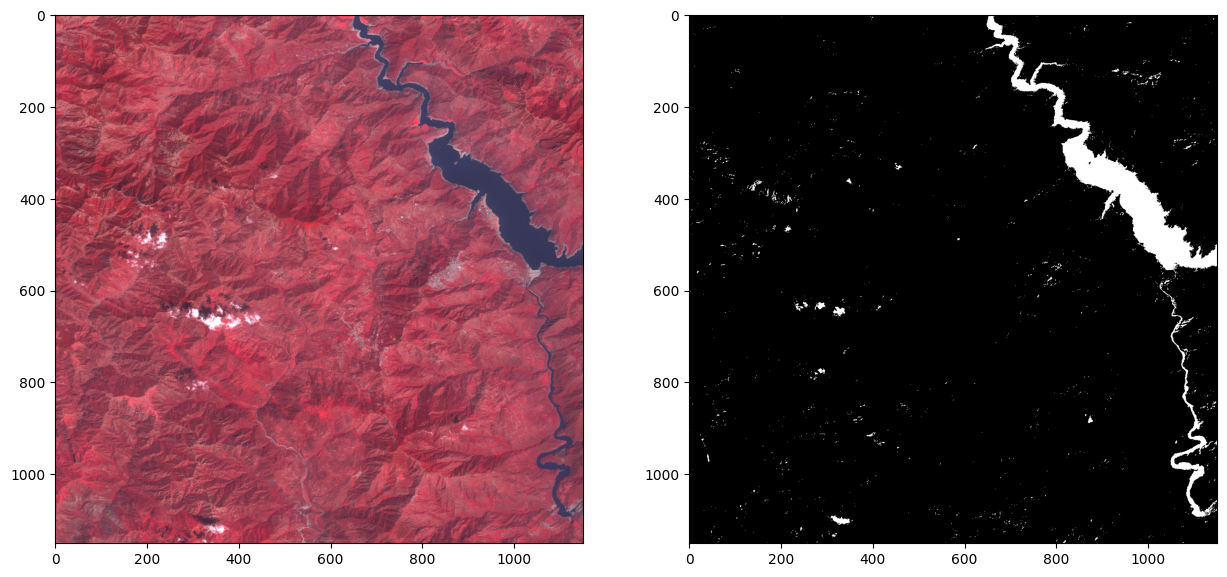

In [ ]:
fig, (axs1, axs2) = plt.subplots(1,2 , figsize=(15,10))
axs1.imshow(np.stack((data[2], data[1], data[0]), axis=-1))
axs2.imshow(water_map, cmap='gray')


## 5. Output predicted raster to GeoTiff

We can then output our raster array into a GeoTiff file for further analysis. We can produce Cloud Optimized GeoTIFF (COG) files in this step by simply change the 'GTiff' driver to 'COG'.

In [ ]:
predictedPath = 'Water_Map.tif'

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, 1151, 1151, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(ds.GetGeoTransform())
outDs.SetProjection(ds.GetProjection())
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(water_map)
outBand.SetNoDataValue(0)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Lnad Cover Classification using Sentinel-2 Data

The European Space Agency (ESA) WorldCover 10 m 2020 product provides a global land cover map for 2020 at 10 m resolution based on Sentinel-1 and Sentinel-2 data. The WorldCover product comes with 11 land cover classes.
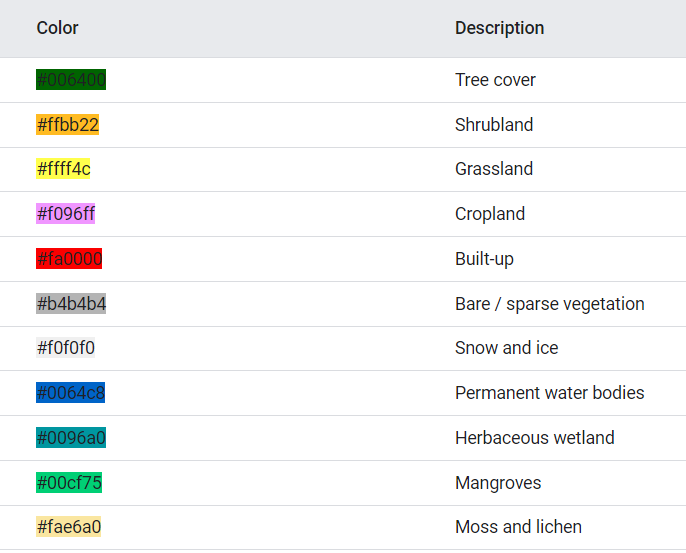

# Sentinel-2
Sentinel-2 is a wide-swath, high-resolution, multi-spectral imaging mission supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas.
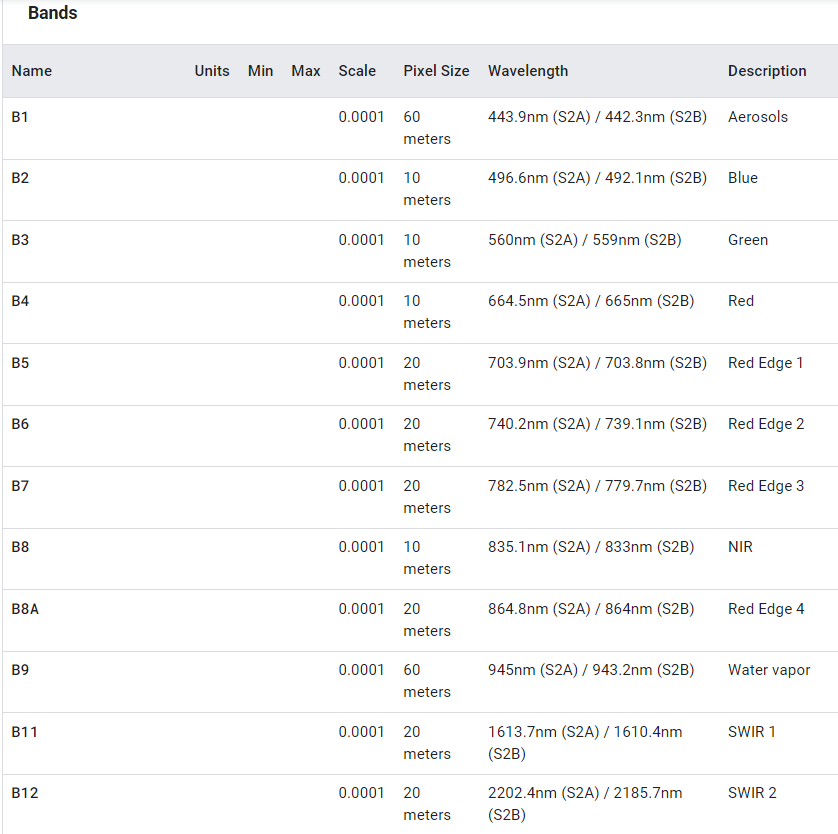

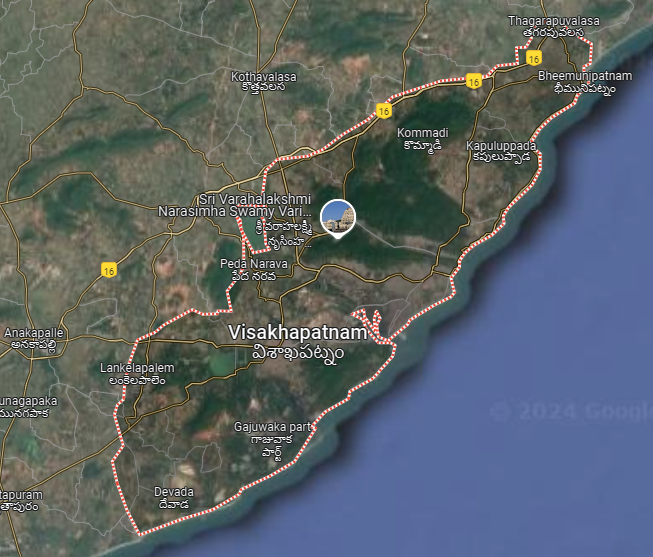


# Preparing Training Data
The training data are landcover labels with a single vector of Sentinel-2  pixel values (Blue, Green, Red, NIR, SWIR-1, SWIR-2) as predictors.

In [ ]:
BANDS = ['Blue',	'Green',	'Red',	'NIR'	,'SWIR-1',	'SWIR-2']
INPUT_TILE_X_DIM = 1
INPUT_TILE_Y_DIM = 1
BATCH_SIZE = 16
OUTPUT_CLASS = 'Landcover'

In [ ]:
df = pd.read_csv('vizag_sample_data.csv')

In [ ]:
df

,Blue,Green,Red,NIR,SWIR-1,SWIR-2,Landcover
0,0.05615,0.07725,0.07125,0.2460,0.1879,0.10925,10
1,0.06420,0.08150,0.08410,0.1981,0.1975,0.13895,10
2,0.07080,0.08790,0.08500,0.1794,0.1655,0.11360,10
3,0.06100,0.08450,0.07795,0.2668,0.1812,0.09990,10
4,0.06730,0.08770,0.08190,0.2382,0.1906,0.12200,10
...,...,...,...,...,...,...,...
7995,0.07010,0.08500,0.06120,0.2618,0.1786,0.09260,90
7996,0.05050,0.06590,0.05070,0.1144,0.0746,0.03850,90
7997,0.04370,0.05260,0.04070,0.0466,0.0196,0.01280,90
7998,0.09440,0.12280,0.14540,0.2120,0.2535,0.20940,90


In [ ]:
df['Landcover'] = df['Landcover'] // 10

In [ ]:
df['Landcover'].value_counts()

,count
Landcover,
1,1000
2,1000
3,1000
4,1000
5,1000
6,1000
8,1000
9,1000


# Training and Test Split

In [ ]:
X = df[BANDS]
y = df[OUTPUT_CLASS]

# Split the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
print('Training Data Size',len(X_train))
print('Testing Data Size',len(X_test))

Training Data Size 5600
Testing Data Size 2400


# Random Forest Training

 First we will walk through the fundamentals of a Random Forest algorithm. Next,we will perform some training using the Random Forest algorithm. Finally, we will perform inference using the Random Forest algorith, and will include some metrics to analyze its performance.

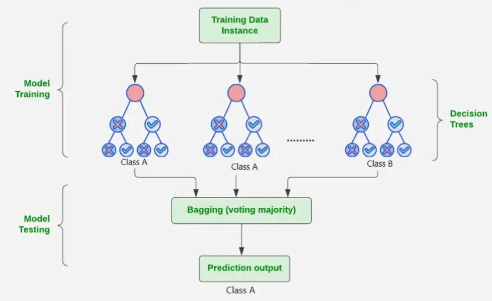

In [ ]:
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

## 4. Training Preparation

Once we have our training and test data ready, we proceed to prepare for training our model. One technique often used to better validate the robustness of a machine learning model is K-fold cross validation.

Cross-validation is a statistical method used to estimate the skill of machine learning models. When using k-fold, the dataset is split into ‘k’ number of subsets, k-1 subsets then are used to train the model and the last subset is kept as a validation set to test the model. Then the score of the model on each fold is averaged to evaluate the performance of the model.

sckit-learn provides a useful feature to quickly setup these experiments. A K of 10 has been described by literature as the most effective value to decrease variance and nominally test performance. In this example, we will use a value of K = 5 for time purposes.

In [ ]:
_ = [print(column) for column in X_train.columns]

Blue
Green
Red
NIR
SWIR-1
SWIR-2


In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Blue,5600.0,0.068634,0.023014,0.0340,0.054200,0.061700,0.076400,0.33780
Green,5600.0,0.086623,0.027714,0.0418,0.069800,0.083025,0.099663,0.40180
Red,5600.0,0.085793,0.039695,0.0272,0.054650,0.082375,0.108800,0.46080
NIR,5600.0,0.187255,0.081304,0.0155,0.154775,0.210600,0.239700,0.47680
SWIR-1,5600.0,0.176858,0.087279,0.0100,0.136675,0.197375,0.237100,0.58755
SWIR-2,5600.0,0.125024,0.068886,0.0072,0.080800,0.138100,0.173000,0.58340


## 5. Model definition and training

In this section we will define our model and train it using our dataset. The hyperparameters listed below are the default from the scikit-learn library, but these are usually very similar across other programming languages. Some of the most useful parameters to know about from the Random Forest are:
- n_estimators: number of trees in the forest
- max_features: max number of features considered for splitting a node
- max_depth: max number of levels in each decision tree
- min_samples_split: min number of data points placed in a node before the node is split
- min_samples_leaf: min number of data points allowed in a leaf node
- bootstrap: method for sampling data points (with or without replacement)

In [ ]:
hyperparameters = {'n_estimators': 400,
                   'criterion':'gini',
                   'max_depth':None,
                   'min_samples_split':5,
                   'min_samples_leaf':1,
                   'min_weight_fraction_leaf':0.0,
                   #'max_features':'auto',
                   'max_leaf_nodes':None,
                   'min_impurity_decrease':0.0,
                   'bootstrap':True,
                   'oob_score':False,
                   'n_jobs':-1,
                   'random_state':42,
                   'verbose':0,
                   'warm_start':True,
                   'class_weight':None,
                   'ccp_alpha':0.0,
                   'max_samples':None,
                   #'classes_':10
                  }

In [ ]:
classifier = skRF(**hyperparameters)

In [ ]:
classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=400, n_jobs=-1,
                       random_state=42, warm_start=True)

In [ ]:
score = classifier.score(X_test, y_test)
print('Average accuracy score: {}'.format(score))

Average accuracy score: 0.6391666666666667


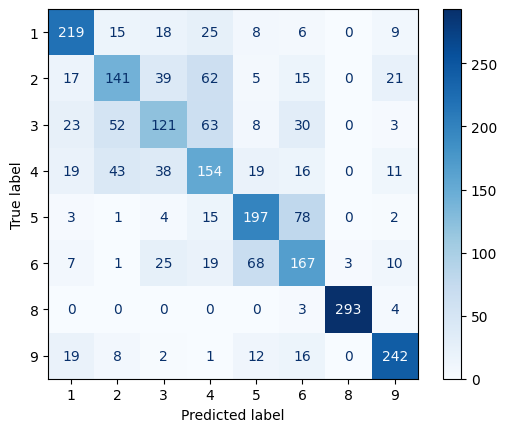

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
    )

# Rster Inference

In [ ]:
ds = gdal.Open('vizag_lulc.tif')

In [ ]:
data = ds.ReadAsArray(band_list=[1,2,3,4,5,6])

In [ ]:
w, h = data.shape[1:]

In [ ]:
df = pd.DataFrame({'Blue':data[0].ravel(), 'Green':data[1].ravel(),
                   'Red':data[2].ravel(), 'NIR':data[3].ravel(), 'SWIR-1':data[4].ravel(),'SWIR-2':data[5].ravel()})

In [ ]:
df.head()

,Blue,Green,Red,NIR,SWIR-1,SWIR-2
0,0.1620,0.2070,0.2400,0.2825,0.32340,0.30830
1,0.1748,0.2176,0.2470,0.2802,0.32340,0.30830
2,0.1718,0.2110,0.2450,0.2762,0.32695,0.30180
3,0.1364,0.1779,0.2124,0.2694,0.32695,0.30180
4,0.1060,0.1465,0.1809,0.2616,0.29640,0.24355


In [ ]:
lulc = classifier.predict(df)

In [ ]:
lulc = lulc.reshape(w,h)

In [ ]:
image = np.stack((data[2], data[1], data[0]), axis=-1) *3

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm

In [ ]:
landcover_colors = [
    '#006400',  # 1: Tree cover
    '#ffbb22',  # 2: Shrubland
    '#ffff4c',  # 3: Grassland
    '#f096ff',  # 4: Cropland
    '#fa0000',  # 5: Built-up
    '#b4b4b4',  # 6: Barren / sparse vegetation
    '#f0f0f0',  # 7: Snow and ice
    '#0064c8',  # 8: Permanent water bodies
    '#0096a0',  # 9: Herbaceous wetland
    '#00cf75',  # 9.5: Mangroves
    '#fae6a0'   # 10: Moss and lichen
]
values =[1, 2, 3, 4, 5, 6, 7, 8, 9, 9.5, 10]
landcover_cmap = ListedColormap(landcover_colors)
norm = BoundaryNorm(boundaries=[.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ncolors=landcover_cmap.N)

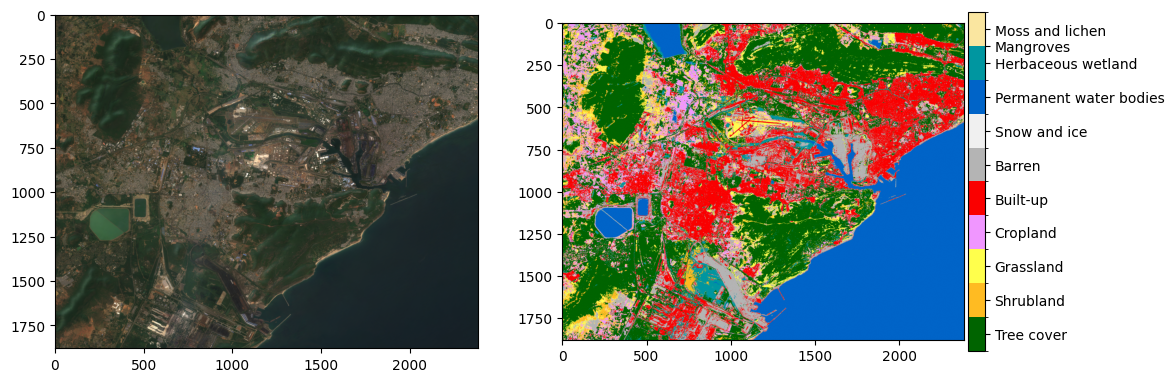

In [ ]:
fig, (axs1, axs2) = plt.subplots(1,2 , figsize=(12,18))
axs1.imshow(image)
cax = axs2.imshow(lulc, cmap=landcover_cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 9.5 ,10],
                    fraction=0.040, pad=0.01)
cbar.set_ticklabels(['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Barren', 'Snow and ice',
                     'Permanent water bodies', 'Herbaceous wetland', 'Mangroves', 'Moss and lichen'])
#axs2.colorbar()

In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

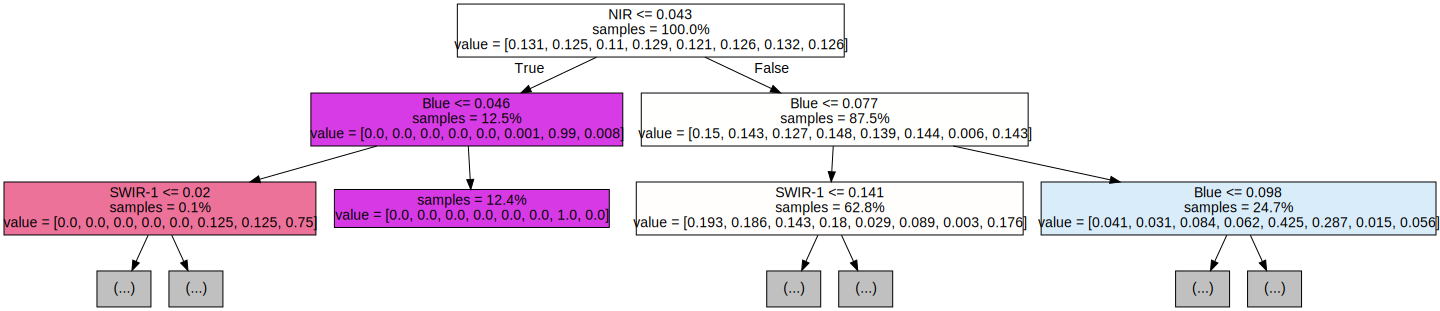

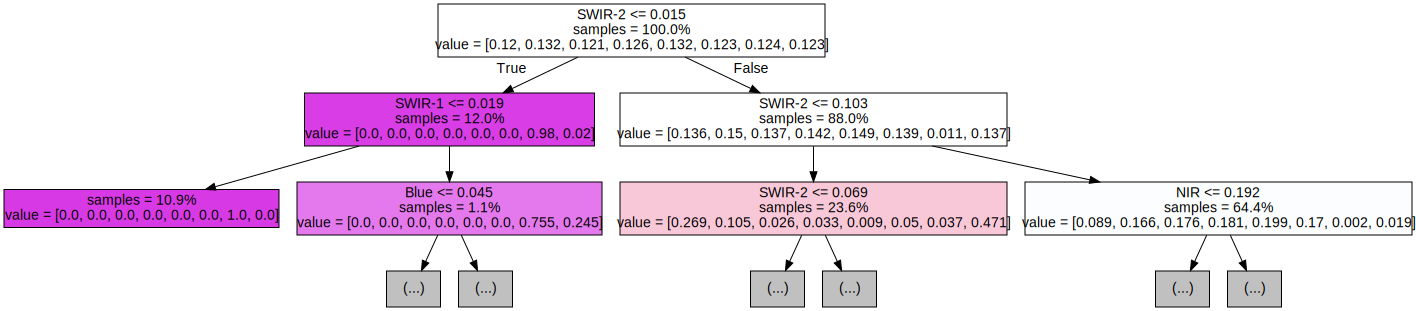

In [ ]:
for i in range(2):
    tree = classifier.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

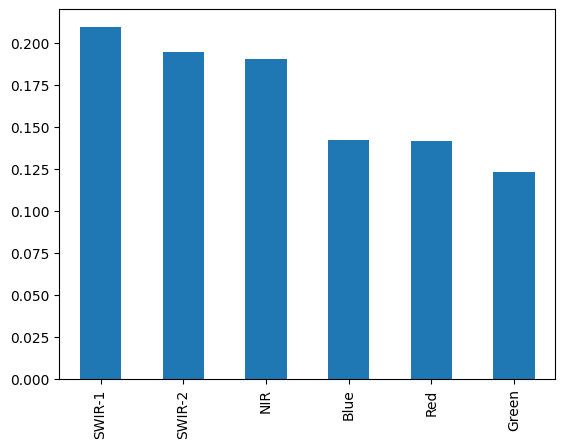

In [ ]:
feature_importances = pd.Series(classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

# Thank You